# 'Recommendation of similar articles from journal abstract analysis'  
# Modeling for recommendation creation
## 2019, Misty M. Giles
### https://github.com/OhThatMisty/astro_categories/

In [1]:
%matplotlib inline

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import spacy
import unicodedata

plt.style.use('fivethirtyeight')

C:\Users\Misty\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Misty\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def normalize(text):
    '''Convert to ascii, remove special characters associated with LaTeX when given a df column,
       only keep alpha chars'''
    normalized_text = []
    
    for t in text:
        t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()
        # This pair is necessary to separate some words because of the LaTeX/mathtext formatting 
        t = re.sub('mathrm|gtrsim|lesssim|odot|langle', ' ', t)
        t = re.sub('rangle|rm off|\\\\\S*|\$\S*\$|\set[\. ]+al[\. ]+', ' ', t) 
        # Collapse terms like x-ray that are disappearing
        t = re.sub(r'\bx-\b', 'x_', t)
        # Remove everthing but alpha, underscores
        t = re.sub('[^a-zA-Z_]+', ' ', remove_stopwords(t))
        # strip_short gets rid of the rest of the math leftovers
        normalized_text.append(strip_short(t, minsize=2))
    return normalized_text

# This function is to remove excess whitespace 
def remove(token):
    '''Provide feedback on whether a token is excess whitespace'''
    return token.is_space or token.is_digit

# This function ensures that all printouts use the same formula
def join_tokens(sent):
    '''Joins tokens in a sent without whatever is in remove(), adds pronoun back
       in instead of -PRON-'''
    return ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text.lower()
                     for token in sent if not remove(token)])

# This function prevents nested lists that kill the vectorizer
def join_sentences(doc):
    '''Joins sentences in a doc (includes join_tokens)'''
    return ' '.join([join_tokens(sent) for sent in doc.sents])

# Set up spacy to lemmatize the text
nlp = spacy.load('en', disable=['ner'])

###  Change the "docs_to_run" variable in this box to reflect testing/full run.

In [3]:
# Get the csv file created in the cleaning notebook
file = os.path.join('..', 'data', 'astro_intermediate.csv')
df = pd.read_csv(file, index_col=0)
# Shuffle the df so that all times available are represented in both test and train
df = df.sample(frac=1).reset_index(drop=True)

# Set variables for testing speed
docs_to_run = len(df)  # 1000 for testing, len(df) for real processing
train_docs = int(0.98 * docs_to_run)  # 98% training, 2% test
test_docs = docs_to_run - train_docs
print('Setting up to train on', train_docs, 'abstracts.')
print('Setting up test block of', test_docs, 'abstracts.')
print('Total', docs_to_run, 'abstracts in session.')

# Set up the sentences_file needed in later steps
sentences_file = os.path.join('..', 'data', 'astro_normalized_premodel.txt')

Setting up to train on 58772 abstracts.
Setting up test block of 1200 abstracts.
Total 59972 abstracts in session.


### For the next three boxes (4, 5, 6):  Box 4 will take quite awhile to run.  Box 5 writes the result of box 4 to a text file.  Box 6 will stream the text file back into the notebook or recreate the variable "text" that can be used in the rest of the notebook without any more changes.  Box 6 will need to be altered depending on your purpose. 

In [4]:
%%time

# This is the long box - 1h on quad-core, 8G RAM machine.  If you already have the sentences_file
# saved, you can ignore these two boxes and make any alterations you need to in the following box.

# Clean the file (remove punctuation, lowercase, lemmatize, remove 1-char objects --
# most are math/LaTeX formatting leftovers or possessives)
text = [join_sentences(doc) for doc in nlp.pipe(normalize(df.abstract[:docs_to_run]), batch_size=50)]

Wall time: 56min 20s


In [5]:
# Ignore this box if using the sentences_file from GitHub.

# Create a filepath and write out the sentences, removing stopwords to save space on GitHub.
with open(sentences_file, 'w') as out_file:
     for sent in text:
            out_file.write(remove_stopwords(sent) + '\n')

In [6]:
# This is the box where you might need some edits if using the sentences_file.  If you are, 
# results might slightly vary.

# Code for printing out an article from the text file to test it.  Can be used to stream
# if you use the iterator method.

# Iterator method (uncomment all three lines):
#sentences = open(sentences_file, 'r')
#for i, line in enumerate(sentences):
#    if i == 10980: print(line)
        
# Recreate the variable "text" (uncomment 1st, 2nd, 4th):
#with open(sentences_file, 'r') as in_file:
#    text = list(in_file)
# Test that "text" recreated appropriately (printout should be a list with string: ['lots of words'])
#text[10980:10981]

In [117]:
print('Sample abstract to demonstrate cleaning (or verify good import):\n')
print(text[article_idx])

Sample abstract to demonstrate cleaning (or verify good import):

present analysis full orbit spectroscopic phase curve ultra hot jupiter wasp obtain wide field camera aboard hubble space telescope measure planet normalize day night contrast luminosity disk integrate dayside emission planet ppm correspond place upper limit nightside emission ppm sigma level peak phase curve exhibit small significant offset brightness degree eastward compare extract phase curve phase resolve spectra global circulation model broadly datum reproduce model comparison constraint atmospheric property planet firstly need efficient drag explain inefficient day night re circulation observe demonstrate drag lorentz force drag magnetic field weak gauss secondly high metallicity require match large day night temperature contrast fact effect metallicity phase curve different cool gas giant counterpart high temperature chemistry wasp atmosphere additionally compare current uhj spectroscopic phase curve wasp wasp pla

### Model: tfidf using sklearn

In [ ]:
%%time

# Set up the model for vectorizing/calculating the similarity; words must appear 
# in at least 400 documents.   
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=400, max_df=0.9)

# Transform/fit the training and test data to the model
tfidf_matrix = tfidf.fit_transform(text[:train_docs]).todense()
article_matrix = tfidf.transform(text[train_docs:]).todense()

# Create a df of the model's values
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names())
article_df = pd.DataFrame(article_matrix, columns=tfidf.get_feature_names())

In [ ]:
print('Training vocabulary:', len(tfidf.get_feature_names()))
print('Stopwords:', len(tfidf.stop_words_))

In [124]:
# Remove the stopwords to free up some memory
delattr(tfidf, 'stop_words_')

AttributeError: stop_words_

###  Now that the model has been prepared, it's time to choose a sample abstract from the test set.  This is a proof-of-concept method for a recommendation engine that suggests articles based on the abstract you're reading.  As it's proof-of-concept, the abstract will be randomly chosen for you from the test abstracts.  (Abstract and highest-rated related abstract shown at bottom of notebook.)

In [146]:
# Pick an article to function as the sample 
article_idx = np.random.randint(0, test_docs)

# Uncomment the line below if you want to see the cleaned data from the new sample
#text[article_idx+train_docs:article_idx+train_docs+1]

#### Finding recommendations from tfidf and cosine similarity, using the sample abstract above.

In [147]:
# Compute the document similarities with sklearn linear_kernel.  Per sklearn,
# linear_kernal is faster than cosine_similarity for tfidf.
document_similarity = linear_kernel(article_df.iloc[article_idx:article_idx+1], tfidf_df).flatten()

# Get the indices for the documents that have highest cosine similarity to the sample.
related_indices = document_similarity.argsort()[:-7:-1]
related_indices

array([31861,  2748,  1955, 23459, 23715, 28188], dtype=int64)

In [148]:
# Create a df with the attributes of the similar documents
related_abstracts = df[['abstract', 'title', 'terms']].iloc[related_indices]
related_abstracts['document_similarity'] = document_similarity[related_indices]

# Print out the most similar documents
related_abstracts

,abstract,title,terms,document_similarity
31861,Nearby star-forming galaxies offer a unique en...,Different generations of HMXBs: clues about th...,astro-ph.HE,0.503205
2748,We have identified 55 candidate high-mass X-ra...,Formation Timescales for High-Mass X-ray Binar...,astro-ph.HE|astro-ph.GA,0.479234
1955,[abridged] How does a star cluster of more tha...,NGC 346: Looking in the Cradle of a Massive St...,astro-ph.GA,0.455667
23459,We present 15 high mass X-ray binary (HMXB) ca...,Young Accreting Compact Objects in M31: The Co...,astro-ph.HE,0.446389
23715,The 30 Doradus star-forming region in the Larg...,An excess of massive stars in the local 30 Dor...,astro-ph.SR|astro-ph.GA,0.440245
28188,The objective of this work is to study how act...,Quenching by gas compression and consumption: ...,astro-ph.GA|astro-ph.CO,0.431887


### How much does the first result ("recommended abstract" from now on) have in common with the sample?  This table (sorted by feature importance of the sample article) shows how many and which of the top features match up.

In [149]:
# Get the features of the sample abstract
sample_features = dict(article_df.iloc[article_idx])
sample_features = pd.DataFrame.from_dict(sample_features, orient='index').reset_index()
sample_features.columns = ['feature', 'sample_importance']
# Get the features for the recommended abstract
related_features = dict(tfidf_df.iloc[related_indices[0]])
related_features = pd.DataFrame.from_dict(related_features, orient='index').reset_index()
related_features.columns = ['feature', 'recommended_importance']
# Concat dfs
features_df = sample_features.merge(related_features, on='feature')
features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]

,feature,sample_importance,recommended_importance
1986,star,0.288187,0.222307
1991,star formation,0.247674,0.076422
793,formation,0.239517,0.177373
2272,x_ray,0.230971,0.213804
58,ago,0.199327,0.000000
2273,x_ray binary,0.192241,0.118635
1204,magellanic cloud,0.191314,0.118063
1203,magellanic,0.189575,0.116991
2128,time,0.164884,0.101753
1355,myr,0.163825,0.202199


### But what features were most important for the recommended article?

In [150]:
related_features.sort_values(by='recommended_importance', ascending=False)[:5]

,feature,recommended_importance
1573,population,0.288762
1501,parent,0.251988
1986,star,0.222307
199,binary,0.220541
2272,x_ray,0.213804


##### Here are the full, unaltered abstracts from the sample and the first recommended article.

In [151]:
# Get the abstract for the sample article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('ABSTRACT TO MATCH: \n', df.url.iloc[(article_idx + train_docs)], '\n')
print(df.title.iloc[(article_idx + train_docs)], '\n')
print(df.abstract.iloc[(article_idx + train_docs)], '\n')
print(df.terms.iloc[(article_idx + train_docs)])

ABSTRACT TO MATCH: 
 http://arxiv.org/abs/1603.08011v2 

Star-formation history and X-ray binary populations: the case of the   Large Magellanic Cloud 

In the present work we investigate the link between high-mass X-ray binaries (HMXBs) and star formation in the Large Magellanic Cloud (LMC), our nearest star-forming galaxy. Using optical photometric data, we identify the most likely counterpart of 44 X-ray sources. Among the 40 HMXBs classified in this work, we find 33 Be/X-ray binaries, and 4 supergiant XRBs. Using this census and the published spatially resolved star-formation history map of the LMC, we find that the HMXBs (and as expected the X-ray pulsars) are present in regions with star-formation bursts $\sim$6-25 Myr ago, in contrast to the Small Magellanic Cloud (SMC), for which this population peaks at later ages ($\sim$25-60 Myr ago). We also estimate the HMXB production rate to be equal to 1 system per $\sim43.5\times10^{-3}$ Mo/yr, or 1 system per $\sim$143 Mo of stars for

In [152]:
# Get the abstract for the recommended article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('HIGHEST-RATED MATCH \n', df.url.iloc[related_indices[0]], '\n')
print(df.title[related_indices[0]], '\n')
print(df.abstract[related_indices[0]], '\n')
print(df.terms[related_indices[0]])

HIGHEST-RATED MATCH 
 http://arxiv.org/abs/1812.11070v1 

Different generations of HMXBs: clues about their formation efficiency   from Magellanic Clouds studies 

Nearby star-forming galaxies offer a unique environment to study the populations of young ($<$100 Myr) accreting binaries. These systems are tracers of past populations of massive stars that heavily affect their immediate environment and parent galaxies. Using a Chandra X-ray Visionary program, we investigate the young neutron-star binary population in the low metallicity of the Small Magellanic Cloud (SMC) by reaching quiescent X-ray luminosity levels ($\sim$few times $10^{32}$ erg/s). We present the first measurement of the formation efficiency of high-mass X-ray binaries (HMXBs) as a function of the age of their parent stellar populations by using 3 indicators: the number ratio of HMXBs to OB stars, to the SFR, and to the stellar mass produced during the specific star-formation burst they are associated with. In all cases

### Now plots.

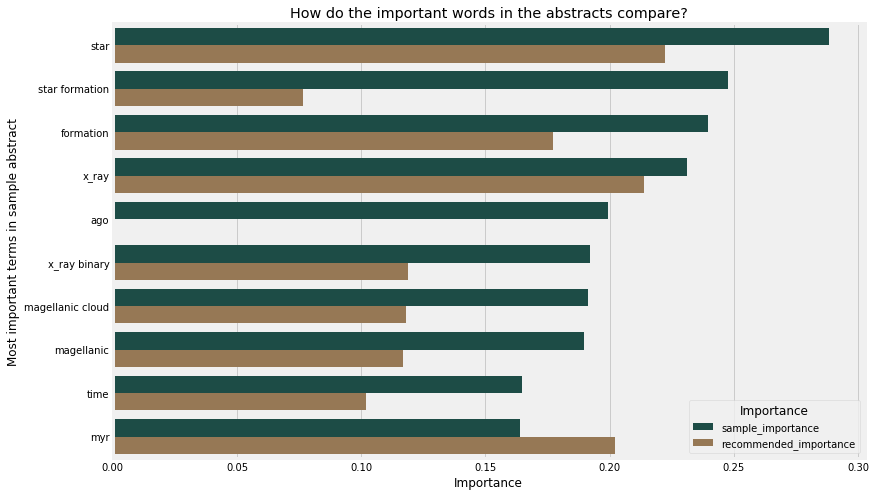

In [153]:
data = features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]
tidy = data.melt(id_vars='feature').rename(columns=str.lower)
tidy.columns = ['feature', 'Importance', 'value']
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x='value', y='feature', hue='Importance', data=tidy, palette=sns.color_palette("cubehelix", 3))
_ = plt.xlabel('Importance')
_ = plt.ylabel('Most important terms in sample abstract')
_ = plt.title('How do the important words in the abstracts compare?')